<a href="https://colab.research.google.com/github/boris-kanga/CaptchaSolver/blob/master/CaptchaSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install imutils
!pip install sklearn
!pip install tensorflow
!pip install keras

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
repo_url = 'https://github.com/boris-kanga/CaptchaSolver.git'
%cd /content

!git clone {repo_url}
%cd /content/CaptchaSolver


/content
Cloning into 'CaptchaSolver'...
remote: Enumerating objects: 2727, done.
remote: Counting objects: 100% (2506/2506), done.
remote: Compressing objects: 100% (2505/2505), done.
remote: Total 2727 (delta 1), reused 2504 (delta 0), pack-reused 221
Receiving objects: 100% (2727/2727), 3.80 MiB | 1024.00 KiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/CaptchaSolver


In [ ]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit

In [ ]:
batch_size = 32
img_height = 20
img_width = 20
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "/content/CaptchaSolver/captcha_model.tflite"
MODEL_LABELS_FILENAME = "model_labels.text"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  LETTER_IMAGES_FOLDER,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2171 files belonging to 10 classes.
Using 1737 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  LETTER_IMAGES_FOLDER,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2171 files belonging to 10 classes.
Using 434 files for validation.


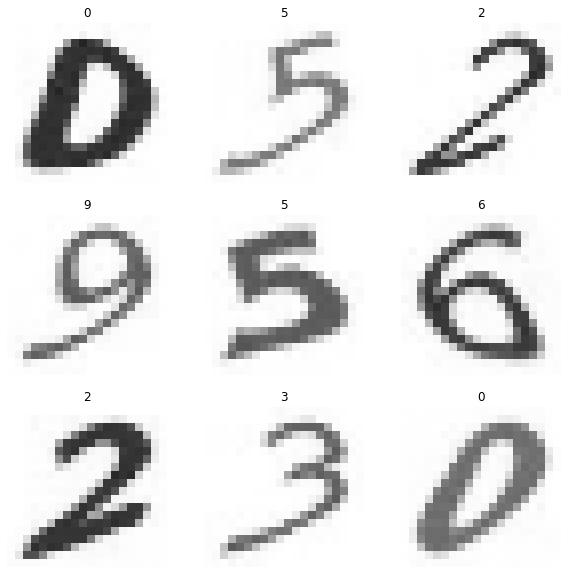

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
num_classes = 10

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#model.summary()

In [ ]:
# Train the neural network
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
55/55 [==============================] - 21s 31ms/step - loss: 2.2430 - accuracy: 0.1586 - val_loss: 1.7389 - val_accuracy: 0.4977
Epoch 2/10
55/55 [==============================] - 1s 19ms/step - loss: 1.3174 - accuracy: 0.5954 - val_loss: 0.4015 - val_accuracy: 0.8986
Epoch 3/10
55/55 [==============================] - 1s 19ms/step - loss: 0.3519 - accuracy: 0.8990 - val_loss: 0.1393 - val_accuracy: 0.9724
Epoch 4/10
55/55 [==============================] - 1s 19ms/step - loss: 0.1373 - accuracy: 0.9648 - val_loss: 0.0549 - val_accuracy: 0.9908
Epoch 5/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0632 - accuracy: 0.9863 - val_loss: 0.0428 - val_accuracy: 0.9931
Epoch 6/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0570 - accuracy: 0.9892 - val_loss: 0.0336 - val_accuracy: 0.9954
Epoch 7/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0457 - accuracy: 0.9890 - val_loss: 0.0289 - val_accuracy: 0.9931
Epoch 8/10
5

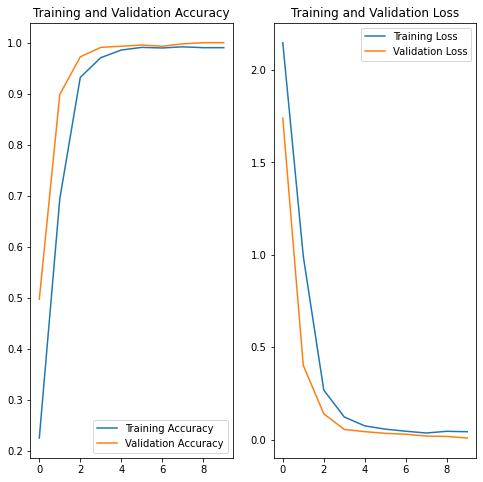

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img( "/content/CaptchaSolver/extracted_letter_images/8/000001.png"
    , target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to 8 with a 99.90 percent confidence.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(MODEL_FILENAME, 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save('/content/drive/MyDrive/Model-captcha/captcha_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model-captcha/captcha_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model-captcha/captcha_model/assets


In [6]:
#Import packages

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#loadModel
from google.colab import drive
drive.mount('/content/drive')

MODEL_FILENAME = "/content/drive/MyDrive/Model-captcha/captcha_model"
model = tf.keras.models.load_model(MODEL_FILENAME)

In [ ]:

batch_size = 32
img_height = 20
img_width = 20
LETTER_IMAGES_FOLDER = "extracted_letter_images"

def get_number_from_image(path,img_width=20,img_height=20):
  class_names=[0,1,2,3,4,5,6,7,8,9]
  img = keras.preprocessing.image.load_img( path, target_size=(img_height, img_width))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  return class_names[np.argmax(score)]

In [77]:
### resolution captcha
def split_image(path):
  # Load image, convert to grayscale, and find edges
  image = cv2.imread(path)
  gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
  bordersize=10

  gray = cv2.copyMakeBorder(
    gray,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]
  )
  thresh = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY)[1]
  #cv2.imwrite('output_masked.png', thresh)
  cnts = cv2.findContours(thresh, 1,2)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  
  h_min=15
  w_min=15
  crops_regions=[]

  for c in cnts[:-1]:
      x,y,w,h = cv2.boundingRect(c)
      if h>=h_min and w>=w_min:
        cx=(2*x+w)/2
        cy=(2*y+h)/2
        ignore=False
        for index, r in enumerate(crops_regions):
          if r[0]<=cx<=r[0]+r[2] and r[1]<=cy<=r[1]+r[3]:
            ignore=True
            break
          cxx=r[0]+(r[2])/2
          cyy=r[1]+(r[3])/2
          if x<=cxx<=x+w and y<=cyy<=y+h and r[2]>=w and r[3]>=h:
            ignore=True
            crops_regions[index]=(x,y,w,h)
            break
        if not ignore:
          crops_regions.append((x,y,w,h))
  
  i=0
  final =sorted(crops_regions, key=lambda region: region[0])
  save_path="/content/temp/captcha_"+str(time.time())
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  cv2.imwrite(save_path+"/thres.png",thresh)
  images_name_saved=[]
  for region in final:
      x,y,w,h=region
      letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
      img_name=f'{save_path}/part_{i}.png'
      cv2.imwrite(img_name,letter_image)
      images_name_saved.append(img_name)
      i+=1
  return images_name_saved

def solve(path):
  try:
    images_name_saved=split_image(path)
    print(images_name_saved)
    text=""
    for img in images_name_saved:
      text+=str(get_number_from_image(img))
    return text
  except Exception as ex:
    print(ex)



In [ ]:
captcha_path="/content/CaptchaSolver/images_captcha_générées/5212.jpg"
solve(captcha_path)


This image most likely belongs to 5 with a 99.99 percent confidence.
This image most likely belongs to 2 with a 99.95 percent confidence.
This image most likely belongs to 1 with a 99.98 percent confidence.
This image most likely belongs to 2 with a 99.99 percent confidence.


'5212'

/content/test_online/15.png
False
False
False
False
False
False
True
True
['/content/temp/captcha_1624392040.0166037/part_0.png', '/content/temp/captcha_1624392040.0166037/part_1.png', '/content/temp/captcha_1624392040.0166037/part_2.png', '/content/temp/captcha_1624392040.0166037/part_3.png', '/content/temp/captcha_1624392040.0166037/part_4.png', '/content/temp/captcha_1624392040.0166037/part_5.png']
This image most likely belongs to 0 with a 99.65 percent confidence.
This image most likely belongs to 5 with a 99.86 percent confidence.
This image most likely belongs to 2 with a 99.81 percent confidence.
This image most likely belongs to 2 with a 99.64 percent confidence.
This image most likely belongs to 0 with a 97.93 percent confidence.
This image most likely belongs to 8 with a 99.78 percent confidence.
052208


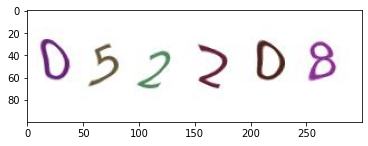

In [101]:
import shutil
import requests
from PIL import Image
import matplotlib.pyplot as plt

save_file_capctha="/content/test_online"
base_url="https://rdv-etrangers-94.interieur.gouv.fr/eAppointmentpref94/captcha?"
params=15
    
filename = f"{save_file_capctha}/{params}.png"
src=base_url+str(params)
response = requests.get(src, stream=True)
with open(filename, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
print(filename)
print(solve(filename))
im = cv2.imread(filename)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
